In [1]:
# SPDX-License-Identifier: MIT
#
# Copyright (c) [2025] [Henry Besser]
#
# This software is licensed under the MIT License.
# See the LICENSE file in the project root for the full license text.

# demos/multi_agent_langgraph_demo.ipynb

# Multi-Agent Demo: LangGraph + Recursive Agents

## Combining Workflow Orchestration with Agent Introspection

This notebook demonstrates how Recursive Agents agents integrate with LangGraph workflows. Since RA agents are callables, they work seamlessly as LangGraph nodes while preserving their thinking transparency.

### What This Demo Shows:

1. **Integration**: How RA agents become LangGraph nodes
2. **Workflow Execution**: Running agents through LangGraph's orchestration
3. **Debug Visibility**: What LangGraph's debug stream provides
4. **Thinking History**: How RA's introspection remains accessible

The key insight: you get both workflow management and agent reasoning visibility without choosing between them.

For detailed analysis, see [`docs/LangGraph_RA_comp.md`](../docs/LangGraph_RA_comp.md)

In [2]:
#from dotenv import load_dotenv
#load_dotenv()

True

In [3]:
import os
api_key_status = "Loaded" if os.getenv("OPENAI_API_KEY") else "NOT FOUND - Check your .env file and environment."
print(f"OpenAI API Key status: {api_key_status}")

OpenAI API Key status: Loaded


In [5]:
# imports
from IPython.display import Image, display, Markdown
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from typing import TypedDict
from recursive_agents.base import MarketingCompanion, BugTriageCompanion, StrategyCompanion

In [6]:
# different models for differents domains
llm_fast  = "gpt-4o-mini"
llm_deep  = "gpt-4.1-mini" 

In [7]:
# create the agents
# tip read the doctring by hovering over the class
mkt   = MarketingCompanion(llm=llm_fast, temperature=0.8, max_loops=3, similarity_threshold=0.96)
eng   = BugTriageCompanion(llm=llm_deep, temperature=0.3)
plan = StrategyCompanion(llm=llm_fast)

In [8]:
# RA companions work as drop-in LangGraph nodes!
# The __call__ method makes them compatible with RunnableLambda
# No special integration needed - they just work together

mkt_node  = RunnableLambda(mkt)          # Marketing companion → LangGraph node
eng_node  = RunnableLambda(eng)          # Engineering companion → LangGraph node

# Now these nodes have BOTH:
# - LangGraph's orchestration capabilities (streaming, retries, etc.)
# - RA's thinking transparency (critique/revision history)

In [9]:
# merge-lambda joins text views into one string
# note: LangGraph passes the entire upstream-state dict to a node.
# with out this function, two upstream nodes are piped straight into strategy, 
# so plan_node will receive a Python dict like {"engineering": "...", "marketing": "..."}.
# That's fine if your StrategyCompanion prompt expects that JSON blob, 
# but most of the time you'll want to concatenate the two strings first.

merge_node = RunnableLambda(
    lambda d: f"### Marketing\n{d['marketing']}\n\n### Engineering\n{d['engineering']}"
)
plan_node  = RunnableLambda(plan)

# Define the state schema for LangGraph
class GraphState(TypedDict):
    input: str
    marketing: str
    engineering: str
    merged: str
    final_plan: str

# Inline LangGraph example (fan-in)
# No extra prompts, no schema gymnastics: simply passing text between the callables the classes already expose.
graph = StateGraph(GraphState)
graph.add_node("marketing_agent",    lambda state: {"marketing": mkt_node.invoke(state["input"])})
graph.add_node("engineering_agent",  lambda state: {"engineering": eng_node.invoke(state["input"])})
graph.add_node("merge_agent",        lambda state: {"merged": merge_node.invoke(state)})
graph.add_node("strategy_agent",     lambda state: {"final_plan": plan_node.invoke(state["merged"])})

graph.add_edge("marketing_agent", "merge_agent")
graph.add_edge("engineering_agent", "merge_agent")
graph.add_edge("merge_agent", "strategy_agent")

graph.add_edge("__start__", "marketing_agent")
graph.add_edge("__start__", "engineering_agent")
graph.set_finish_point("strategy_agent")
workflow = graph.compile()

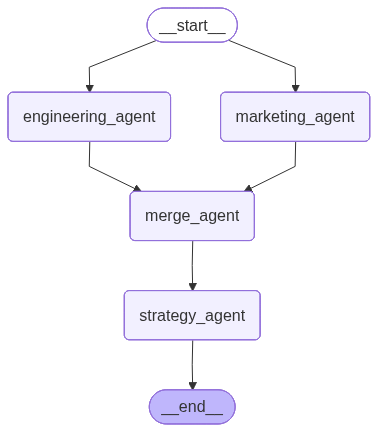

In [10]:
#display the graph
display(Image(workflow.get_graph().draw_mermaid_png()))

## Part 1: LangGraph Debug Stream

### Understanding LangGraph's Structured Debug Data

LangGraph provides workflow-level debugging through its debug stream. Let's run the workflow with `stream_mode="debug"` to capture structured debug events.

**What you'll see**: Task scheduling, execution order, and results - useful for understanding workflow orchestration.

In [ ]:
# Capture debug stream data with stream_mode="debug"
debug_chunks = []
print("Running workflow with debug mode enabled...\n")

# Note: stream_mode="debug" returns structured debug data
for chunk in workflow.stream(
    {"input": "App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps."},
    stream_mode="debug"
):
    debug_chunks.append(chunk)  # Now we can capture structured data!
    print(chunk)  # Also print for visibility
    print("\n")

### Debug Output Analysis

Now let's see what we captured in our debug chunks:

```python
print(f"Total debug chunks captured: {len(debug_chunks)}")
print(f"Chunk types: {set(chunk.get('type') for chunk in debug_chunks if 'type' in chunk)}")
```

In [17]:
# Analyze what we capturedprint("Total debug chunks captured: {len(debug_chunks)}")
print(f"Chunk types: {set(chunk.get('type') for chunk in debug_chunks if 'type' in chunk)}")

# Extract task results
task_results = [chunk for chunk in debug_chunks if chunk.get('type') == 'task_result']
print(f"\nTask results found: {len(task_results)}")
for result in task_results:
    print(f"  - {result.get('payload', {}).get('name', 'unknown')}")

# Add this to print the actual text
payload = result.get('payload', {})
if 'result' in payload and payload['result']:
    text = payload['result'][0][1]

Chunk types: {'task_result', 'task'}

Task results found: 4
  - marketing_agent
  - engineering_agent
  - merge_agent
  - strategy_agent


### Extracting Results from Debug Chunks

Let's extract the actual agent outputs from the debug stream:

In [16]:
# Extract results from debug chunks
extracted_results = {}

for chunk in debug_chunks:
    if chunk.get('type') == 'task_result':
        payload = chunk.get('payload', {})
        agent_name = payload.get('name', 'unknown')
        
        # Navigate the nested structure to get the result
        if 'result' in payload and payload['result']:
            # Result is in format: [(key, value)]
            result_value = payload['result'][0][1]
            extracted_results[agent_name] = result_value

# Show what we extracted
print("Extracted agent outputs from debug stream:")
for agent, output in extracted_results.items():
    print(f"\n{agent}:")
    print(f"{output[:200]}..." if len(output) > 200 else output)

Extracted agent outputs from debug stream:

marketing_agent:
The app's rating has decreased to 3.2 stars, primarily due to upload crashes specifically occurring on iOS 17.2. This situation highlights several underlying issues related to app performance and user...

engineering_agent:
**Executive Summary**  
The app’s average rating has dropped to 3.2 stars, primarily due to frequent crashes occurring during user-initiated file uploads on devices running iOS 17.2. These crashes cau...

merge_agent:
### Marketing
The app's rating has decreased to 3.2 stars, primarily due to upload crashes specifically occurring on iOS 17.2. This situation highlights several underlying issues related to app perfor...

strategy_agent:
### Integrated Overview of Marketing and Engineering Perspectives

**Current Situation and Key Issues**

Our app's rating has fallen to 3.2 stars, indicating significant user dissatisfaction compared ...


---

## Part 2: Accessing RA's Built-in Introspection

#### Note: Running the compiled workflow again to show RA's automatic history tracking

Now let's run the workflow normally and access the thinking history that RA agents automatically preserve:

In [18]:
# Run the workflow again - this time WITHOUT debug mode
# This is what you'd typically do in production
result = workflow.invoke(
    {"input": "App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps."}
)

print("Workflow completed successfully!")

Workflow completed successfully!


In [19]:
final = result.get("final_plan", "")

In [ ]:
print("\n=== FINAL PLAN ===\n")
display(Markdown(final))

In [31]:
# === After LangGraph workflow completes ===
print("DEEP INTROSPECTION - What LangGraph can't normally show you - available without any special configuration::\n")
# Show why each converged
print("=" * 80)
print("COMPLETE CONVERGENCE ANALYSIS")
print("=" * 80)

for name, agent in [("Marketing", mkt), ("Engineering", eng), ("Strategy", plan)]:
    print(f"\n{name} Companion:")
    print(f"  • Model: {agent.llm.model_name}")
    print(f"  • Temperature: {agent.llm.temperature}")
    print(f"  • Iterations: {len(agent.run_log)}/{agent.max_loops}")
    print(f"  • Similarity threshold: {agent.similarity_threshold}")
    
    # Determine convergence type
    last_critique = agent.run_log[-1]['critique'].lower()
    if "no further improvements" in last_critique or "minimal revisions" in last_critique:
        convergence = "Critique-based (no improvements needed)"
    elif len(agent.run_log) < agent.max_loops:
        convergence = "Similarity-based (threshold reached)"
    else:
        convergence = "Max iterations reached"
    print(f"  • Convergence: {convergence}")

# Want to see the last critique? Just access it directly!
print("\n Strategy's final critique (no parsing needed) (first 300 chars):")
print(f"{plan.run_log[-1]['critique'][:300]}...")

DEEP INTROSPECTION - What LangGraph can't normally show you - available without any special configuration::

COMPLETE CONVERGENCE ANALYSIS

Marketing Companion:
  • Model: gpt-4o-mini
  • Temperature: 0.8
  • Iterations: 2/3
  • Similarity threshold: 0.96
  • Convergence: Similarity-based (threshold reached)

Engineering Companion:
  • Model: gpt-4.1-mini
  • Temperature: 0.3
  • Iterations: 3/3
  • Similarity threshold: 0.98
  • Convergence: Max iterations reached

Strategy Companion:
  • Model: gpt-4o-mini
  • Temperature: 0.7
  • Iterations: 2/3
  • Similarity threshold: 0.97
  • Convergence: Similarity-based (threshold reached)

 Strategy's final critique (no parsing needed) (first 300 chars):
### Critique of Integrated Overview of Marketing and Engineering Perspectives

1. **Clarity and Structure**:
   - **Issue**: The overall structure lacks a clear delineation between the sections, making it hard for readers to follow the flow of information. For instance, the transition between

### The Complete Thinking History

Now let's see what the debug stream couldn't show us - the complete Draft → Critique → Revision cycles for each agent:

In [ ]:
# Show full thinking process for each agent
print("\n MARKETING THINKING PROCESS:")
display(Markdown(mkt.transcript_as_markdown()))

In [ ]:
print("\n ENGINEERING THINKING PROCESS:")
display(Markdown(eng.transcript_as_markdown()))

In [ ]:
print("\n STRATEGY SYNTHESIS PROCESS:")
display(Markdown(plan.transcript_as_markdown()))

For detailed analysis see [`docs/LangGraph_RA_comp.md`](../docs/LangGraph_RA_comp.md)